https://www.kaggle.com/vikazrajpurohit/3-model-training-and-inference

# Features

In [1]:
# import
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
 
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import warnings
warnings.filterwarnings('ignore')

In [5]:
# seed
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [2]:
# data
data_dir = './data/lish-moa/'

train_feat = pd.read_csv(data_dir + 'train_features.csv')
scored = pd.read_csv(data_dir + 'train_targets_scored.csv')
nonscored = pd.read_csv(data_dir + 'train_targets_nonscored.csv')
drugs = pd.read_csv(data_dir + 'train_drug.csv')
test_feat = pd.read_csv(data_dir + 'test_features.csv')
submission = pd.read_csv(data_dir + 'sample_submission.csv')

print('train_features: {}'.format(train_feat.shape))
print('train_targets_scored: {}'.format(scored.shape))
print('train_targets_nonscored: {}'.format(nonscored.shape))
print('train_drug: {}'.format(drugs.shape))
print('test_features: {}'.format(test_feat.shape))
print('sample_submission: {}'.format(submission.shape))

train_features: (23814, 876)
train_targets_scored: (23814, 207)
train_targets_nonscored: (23814, 403)
train_drug: (23814, 2)
test_features: (3982, 876)
sample_submission: (3982, 207)


In [47]:
len(test_feat.sig_id.unique())

3982

In [3]:
train_feat2=train_feat.copy()
test_feat2=test_feat.copy()

In [4]:
GENES = [col for col in train_feat.columns if col.startswith('g-')]
CELLS = [col for col in test_feat.columns if col.startswith('c-')]

## QuantileTransformer
将train和test的GENES和CELLS转换为normal distribution

In [6]:
# qt for GENES+CELLS
qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
data = pd.concat([pd.DataFrame(train_feat[GENES+CELLS]), pd.DataFrame(test_feat[GENES+CELLS])])
data2 = qt.fit_transform(data[GENES+CELLS])

train_feat[GENES+CELLS] = pd.DataFrame(data2[:train_feat.shape[0]])
test_feat[GENES+CELLS] = pd.DataFrame(data2[-test_feat.shape[0]:])

In [7]:
# pca for GENES
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_feat[GENES]), pd.DataFrame(test_feat[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_feat.shape[0]]; 
test2 = data2[-test_feat.shape[0]:]

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_feat = pd.concat((train_feat, train_gpca), axis=1)
test_feat = pd.concat((test_feat, test_gpca), axis=1)

In [8]:
# pca for CELLS
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_feat[CELLS]), pd.DataFrame(test_feat[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_feat.shape[0]]
test2 = data2[-test_feat.shape[0]:]

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_feat = pd.concat((train_feat, train_cpca), axis=1)
test_feat = pd.concat((test_feat, test_cpca), axis=1)

In [9]:
train_feat.shape,train_feat.shape

((23814, 1526), (23814, 1526))

In [10]:
# var threshold for GENES CELLS features
var_thresh = VarianceThreshold(0.85)  #<-- Update

data = train_feat.append(test_feat)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_feat.shape[0]]
test_features_transformed = data_transformed[-test_feat.shape[0] : ]


train_feat = pd.DataFrame(train_feat[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_feat = pd.concat([train_feat, pd.DataFrame(train_features_transformed)], axis=1)


test_feat = pd.DataFrame(test_feat[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_feat = pd.concat([test_feat, pd.DataFrame(test_features_transformed)], axis=1)

In [11]:
train_feat.shape,train_feat.shape

((23814, 1028), (23814, 1028))

In [12]:
# cluster feature for GENES and CELLS

from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 22, n_clusters_c = 4, SEED = 42):
    
    features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_feat2,test_feat2=fe_cluster(train_feat2,test_feat2)

In [13]:
# cluster for GENES and CELLS PCA features
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        data=pd.concat([train,test],axis=0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_pca'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_pca'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test

train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

In [14]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]

In [15]:
train_features_cluster=train_feat2.iloc[:,876:]
test_features_cluster=test_feat2.iloc[:,876:]

In [16]:
gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']
len(gsquarecols)

45

In [17]:
# statistic feature for GENES and CELLS
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_feat2,test_feat2=fe_stats(train_feat2,test_feat2)

In [19]:
train_features_stats=train_feat2.iloc[:,902:]
test_features_stats=test_feat2.iloc[:,902:]

In [20]:
train_feat.shape,test_feat.shape

((23814, 1028), (3982, 1028))

In [21]:
train_feat = pd.concat((train_feat, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_feat = pd.concat((test_feat, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)

train_feat.shape,test_feat.shape

((23814, 1239), (3982, 1239))

In [22]:
# train,test
train = train_feat.merge(scored, on='sig_id')
train = train.merge(nonscored, on='sig_id')
train = train.merge(drugs, on='sig_id')
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_feat[test_feat['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

train.shape,test.shape

((21948, 1848), (3624, 1239))

In [23]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [24]:
# targets
target_cols = [x for x in scored.columns if x != 'sig_id']
aux_target_cols = [x for x in nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

print('num_targets: {}'.format(num_targets))
print('num_aux_targets: {}'.format(num_aux_targets))
print('num_all_targets: {}'.format(num_all_targets))

num_targets: 206
num_aux_targets: 402
num_all_targets: 608


In [25]:
print(train.shape)
print(test.shape)
print(submission.shape)

(21948, 1847)
(3624, 1238)
(3982, 207)


# Dataset and Train Models

In [26]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }

        return dct

In [27]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    return preds

In [28]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [29]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [30]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []

    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []

        model_new = Model(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())

        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]

            if layer_index == 5:
                continue

            param.requires_grad = False

            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)

        self.epochs_per_step = self.epochs // len(self.frozen_layers)

        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new

    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return

        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]

                if layer_index == last_frozen_index:
                    param.requires_grad = True

            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

In [31]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

feature_cols = [c for c in process_data(train).columns if c not in all_target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id', 'drug_id']]
num_features = len(feature_cols)
num_features

1240

In [40]:
# HyperParameters
DEVICE = ('cuda:1' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

In [33]:
# Show model architecture
model = Model(num_features, num_all_targets)
model

Model(
  (batch_norm1): BatchNorm1d(1240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=1240, out_features=1500, bias=True)
  (batch_norm2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1500, out_features=1250, bias=True)
  (batch_norm3): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (dense3): Linear(in_features=1250, out_features=1000, bias=True)
  (batch_norm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=1000, out_features=750, bias=True)
  (batch_norm5): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (dense5): Linear(in_features=750, out_features=608, 

In [35]:
# cv_folds
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

def make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH):
    vc = train.drug_id.value_counts()
    vc1 = vc.loc[vc <= DRUG_THRESH].index.sort_values()
    vc2 = vc.loc[vc > DRUG_THRESH].index.sort_values()

    for seed_id in range(SEEDS):
        kfold_col = 'kfold_{}'.format(seed_id)
        
        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}
        dct2 = {}

        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.loc[train.drug_id.isin(vc2)].reset_index(drop=True)

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        train[kfold_col] = train.drug_id.map(dct1)
        train.loc[train[kfold_col].isna(), kfold_col] = train.loc[train[kfold_col].isna(), 'sig_id'].map(dct2)
        train[kfold_col] = train[kfold_col].astype('int8')
        
    return train

SEEDS = 7
NFOLDS = 7
DRUG_THRESH = 18

train = make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH)
train.head()

In [37]:
def run_training(fold_id, seed_id):
    seed_everything(seed_id)
    
    train_ = process_data(train)
    test_ = process_data(test)
    
    kfold_col = f'kfold_{seed_id}'
    trn_idx = train_[train_[kfold_col] != fold_id].index
    val_idx = train_[train_[kfold_col] == fold_id].index
    
    train_df = train_[train_[kfold_col] != fold_id].reset_index(drop=True)
    valid_df = train_[train_[kfold_col] == fold_id].reset_index(drop=True)
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=0.001)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf
        
        for epoch in range(EPOCHS):
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)

            train_loss = train_fn(model, optimizer, scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
            print(f"SEED: {seed_id}, FOLD: {fold_id}, {tag_name}, EPOCH: {epoch}, train_loss: {train_loss:.6f}, valid_loss: {valid_loss:.6f}")

            if np.isnan(valid_loss):
                break
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f"{tag_name}_FOLD{fold_id}_.pth")

        return oof

    fine_tune_scheduler = FineTuneScheduler(EPOCHS)

    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.to(DEVICE)

    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)

    # Load the pretrained model with the best loss
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f"ALL_TARGETS_FOLD{fold_id}_.pth"))
    pretrained_model.to(DEVICE)

    # Copy model without the top layer
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)

    # Fine-tune the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)

    # Load the fine-tuned model with the best loss
    model = Model(num_features, num_targets)
    model.load_state_dict(torch.load(f"SCORED_ONLY_FOLD{fold_id}_.pth"))
    model.to(DEVICE)

    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return oof, predictions

In [38]:
def run_k_fold(NFOLDS, seed_id):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold_id in range(NFOLDS):
        oof_, pred_ = run_training(fold_id, seed_id)
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [41]:
from time import time

# Averaging on multiple SEEDS
SEED = [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

time_begin = time()

for seed_id in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed_id)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

time_diff = time() - time_begin

train[target_cols] = oof
test[target_cols] = predictions

SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 0, train_loss: 0.495673, valid_loss: 0.021622
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 1, train_loss: 0.016190, valid_loss: 0.009783
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 2, train_loss: 0.013758, valid_loss: 0.009296
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 3, train_loss: 0.013292, valid_loss: 0.010099
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 4, train_loss: 0.012928, valid_loss: 0.009086
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 5, train_loss: 0.012922, valid_loss: 0.009159
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 6, train_loss: 0.012939, valid_loss: 0.009118
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012852, valid_loss: 0.009215
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012906, valid_loss: 0.009122
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012873, valid_loss: 0.009080
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012865, valid_loss: 0.008974
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012862, valid_loss:

SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 1, train_loss: 0.015410, valid_loss: 0.010803
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 2, train_loss: 0.013533, valid_loss: 0.009826
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 3, train_loss: 0.012859, valid_loss: 0.009801
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 4, train_loss: 0.012900, valid_loss: 0.009733
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 5, train_loss: 0.012877, valid_loss: 0.009778
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 6, train_loss: 0.012821, valid_loss: 0.009818
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 7, train_loss: 0.012785, valid_loss: 0.009654
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 8, train_loss: 0.012792, valid_loss: 0.009827
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 9, train_loss: 0.012761, valid_loss: 0.009691
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 10, train_loss: 0.012780, valid_loss: 0.009662
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 11, train_loss: 0.012734, valid_loss: 0.009592
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 12, train_loss: 0.012706, valid_loss

SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 2, train_loss: 0.013477, valid_loss: 0.010406
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 3, train_loss: 0.013107, valid_loss: 0.009400
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 4, train_loss: 0.012843, valid_loss: 0.009468
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 5, train_loss: 0.012825, valid_loss: 0.009481
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 6, train_loss: 0.012862, valid_loss: 0.009516
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 7, train_loss: 0.012841, valid_loss: 0.009548
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 8, train_loss: 0.012829, valid_loss: 0.009385
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 9, train_loss: 0.012807, valid_loss: 0.009458
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 10, train_loss: 0.012816, valid_loss: 0.009358
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 11, train_loss: 0.012768, valid_loss: 0.009441
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 12, train_loss: 0.012770, valid_loss: 0.009349
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 13, train_loss: 0.012744, valid_los

SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 3, train_loss: 0.012973, valid_loss: 0.010078
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 4, train_loss: 0.013070, valid_loss: 0.009865
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 5, train_loss: 0.012822, valid_loss: 0.009872
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 6, train_loss: 0.012813, valid_loss: 0.009851
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 7, train_loss: 0.012786, valid_loss: 0.009882
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 8, train_loss: 0.012787, valid_loss: 0.009791
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 9, train_loss: 0.012751, valid_loss: 0.009802
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 10, train_loss: 0.012770, valid_loss: 0.009784
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 11, train_loss: 0.012752, valid_loss: 0.009773
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 12, train_loss: 0.012701, valid_loss: 0.009724
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 13, train_loss: 0.012709, valid_loss: 0.009807
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 14, train_loss: 0.012678, valid_lo

SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 4, train_loss: 0.012887, valid_loss: 0.009430
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 5, train_loss: 0.012824, valid_loss: 0.009451
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 6, train_loss: 0.012975, valid_loss: 0.009412
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 7, train_loss: 0.012877, valid_loss: 0.009495
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 8, train_loss: 0.012880, valid_loss: 0.009449
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 9, train_loss: 0.012845, valid_loss: 0.009507
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 10, train_loss: 0.012832, valid_loss: 0.009486
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 11, train_loss: 0.012827, valid_loss: 0.009409
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 12, train_loss: 0.012791, valid_loss: 0.009334
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 13, train_loss: 0.012785, valid_loss: 0.009273
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 14, train_loss: 0.012758, valid_loss: 0.009320
SEED: 1, FOLD: 1, ALL_TARGETS, EPOCH: 15, train_loss: 0.012686, valid_l

SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 5, train_loss: 0.012837, valid_loss: 0.009469
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 6, train_loss: 0.012900, valid_loss: 0.009617
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 7, train_loss: 0.012820, valid_loss: 0.009519
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 8, train_loss: 0.012815, valid_loss: 0.009524
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 9, train_loss: 0.012819, valid_loss: 0.009620
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 10, train_loss: 0.012817, valid_loss: 0.009454
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 11, train_loss: 0.012787, valid_loss: 0.009438
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 12, train_loss: 0.012793, valid_loss: 0.009457
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 13, train_loss: 0.012742, valid_loss: 0.009417
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 14, train_loss: 0.012703, valid_loss: 0.009474
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 15, train_loss: 0.012655, valid_loss: 0.009370
SEED: 1, FOLD: 3, ALL_TARGETS, EPOCH: 16, train_loss: 0.012626, valid_

SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 6, train_loss: 0.012753, valid_loss: 0.009771
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 7, train_loss: 0.012812, valid_loss: 0.009799
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 8, train_loss: 0.012749, valid_loss: 0.009817
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 9, train_loss: 0.012735, valid_loss: 0.009697
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 10, train_loss: 0.012712, valid_loss: 0.009761
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 11, train_loss: 0.012714, valid_loss: 0.009819
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 12, train_loss: 0.012688, valid_loss: 0.009729
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 13, train_loss: 0.012681, valid_loss: 0.009761
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 14, train_loss: 0.012612, valid_loss: 0.009741
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 15, train_loss: 0.012581, valid_loss: 0.009686
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 16, train_loss: 0.012528, valid_loss: 0.009606
SEED: 1, FOLD: 5, ALL_TARGETS, EPOCH: 17, train_loss: 0.012449, valid

SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012706, valid_loss: 0.010447
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012723, valid_loss: 0.010333
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012673, valid_loss: 0.010256
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012684, valid_loss: 0.010264
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012681, valid_loss: 0.010153
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 12, train_loss: 0.012663, valid_loss: 0.010263
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 13, train_loss: 0.012649, valid_loss: 0.010116
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 14, train_loss: 0.012609, valid_loss: 0.010130
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 15, train_loss: 0.012544, valid_loss: 0.010107
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 16, train_loss: 0.012517, valid_loss: 0.010019
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 17, train_loss: 0.012442, valid_loss: 0.009996
SEED: 2, FOLD: 0, ALL_TARGETS, EPOCH: 18, train_loss: 0.012355, vali

SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 8, train_loss: 0.012844, valid_loss: 0.009450
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 9, train_loss: 0.012814, valid_loss: 0.009412
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 10, train_loss: 0.012799, valid_loss: 0.009321
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 11, train_loss: 0.012784, valid_loss: 0.009316
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 12, train_loss: 0.012798, valid_loss: 0.009452
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 13, train_loss: 0.012773, valid_loss: 0.009278
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 14, train_loss: 0.012702, valid_loss: 0.009360
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 15, train_loss: 0.012682, valid_loss: 0.009225
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 16, train_loss: 0.012602, valid_loss: 0.009281
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 17, train_loss: 0.012556, valid_loss: 0.009184
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 18, train_loss: 0.012460, valid_loss: 0.009182
SEED: 2, FOLD: 2, ALL_TARGETS, EPOCH: 19, train_loss: 0.012363, val

SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 9, train_loss: 0.012841, valid_loss: 0.009584
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 10, train_loss: 0.012827, valid_loss: 0.009591
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 11, train_loss: 0.012818, valid_loss: 0.009536
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 12, train_loss: 0.012798, valid_loss: 0.009477
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 13, train_loss: 0.012784, valid_loss: 0.009431
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 14, train_loss: 0.012743, valid_loss: 0.009469
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 15, train_loss: 0.012700, valid_loss: 0.009298
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 16, train_loss: 0.012644, valid_loss: 0.009396
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 17, train_loss: 0.012557, valid_loss: 0.009235
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 18, train_loss: 0.012470, valid_loss: 0.009204
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 19, train_loss: 0.012383, valid_loss: 0.009194
SEED: 2, FOLD: 4, ALL_TARGETS, EPOCH: 20, train_loss: 0.012274, va

SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 10, train_loss: 0.012865, valid_loss: 0.009326
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 11, train_loss: 0.012812, valid_loss: 0.009404
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 12, train_loss: 0.012783, valid_loss: 0.009503
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 13, train_loss: 0.012781, valid_loss: 0.009276
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 14, train_loss: 0.012723, valid_loss: 0.009302
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 15, train_loss: 0.012717, valid_loss: 0.009239
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 16, train_loss: 0.012644, valid_loss: 0.009161
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 17, train_loss: 0.012590, valid_loss: 0.009103
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 18, train_loss: 0.012497, valid_loss: 0.009003
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 19, train_loss: 0.012409, valid_loss: 0.009006
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 20, train_loss: 0.012308, valid_loss: 0.008947
SEED: 2, FOLD: 6, ALL_TARGETS, EPOCH: 21, train_loss: 0.012192, v

SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 11, train_loss: 0.012751, valid_loss: 0.009477
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 12, train_loss: 0.012755, valid_loss: 0.009469
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 13, train_loss: 0.012736, valid_loss: 0.009381
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 14, train_loss: 0.012684, valid_loss: 0.009384
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 15, train_loss: 0.012658, valid_loss: 0.009267
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 16, train_loss: 0.012581, valid_loss: 0.009251
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 17, train_loss: 0.012500, valid_loss: 0.009215
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 18, train_loss: 0.012404, valid_loss: 0.009145
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 19, train_loss: 0.012312, valid_loss: 0.009106
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 20, train_loss: 0.012225, valid_loss: 0.009051
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 21, train_loss: 0.012098, valid_loss: 0.008995
SEED: 3, FOLD: 1, ALL_TARGETS, EPOCH: 22, train_loss: 0.011988, v

SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 12, train_loss: 0.012740, valid_loss: 0.009570
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 13, train_loss: 0.012678, valid_loss: 0.009604
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 14, train_loss: 0.012685, valid_loss: 0.009538
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 15, train_loss: 0.012601, valid_loss: 0.009485
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 16, train_loss: 0.012571, valid_loss: 0.009396
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 17, train_loss: 0.012493, valid_loss: 0.009429
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 18, train_loss: 0.012407, valid_loss: 0.009310
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 19, train_loss: 0.012333, valid_loss: 0.009243
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 20, train_loss: 0.012209, valid_loss: 0.009203
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 21, train_loss: 0.012098, valid_loss: 0.009139
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 22, train_loss: 0.012016, valid_loss: 0.009140
SEED: 3, FOLD: 3, ALL_TARGETS, EPOCH: 23, train_loss: 0.011954, v

SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 13, train_loss: 0.012762, valid_loss: 0.009930
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 14, train_loss: 0.012729, valid_loss: 0.009950
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 15, train_loss: 0.012669, valid_loss: 0.009797
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 16, train_loss: 0.012599, valid_loss: 0.009741
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 17, train_loss: 0.012539, valid_loss: 0.009684
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 18, train_loss: 0.012432, valid_loss: 0.009629
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 19, train_loss: 0.012348, valid_loss: 0.009599
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 20, train_loss: 0.012253, valid_loss: 0.009533
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 21, train_loss: 0.012149, valid_loss: 0.009506
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 22, train_loss: 0.012077, valid_loss: 0.009482
SEED: 3, FOLD: 5, ALL_TARGETS, EPOCH: 23, train_loss: 0.011975, valid_loss: 0.009503
SEED: 3, FOLD: 5, SCORED_ONLY, EPOCH: 0, train_loss: 0.645641, va

SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 14, train_loss: 0.012599, valid_loss: 0.009889
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 15, train_loss: 0.012570, valid_loss: 0.009849
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 16, train_loss: 0.012499, valid_loss: 0.009858
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 17, train_loss: 0.012432, valid_loss: 0.009765
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 18, train_loss: 0.012383, valid_loss: 0.009757
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 19, train_loss: 0.012261, valid_loss: 0.009665
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 20, train_loss: 0.012127, valid_loss: 0.009604
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 21, train_loss: 0.012017, valid_loss: 0.009564
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 22, train_loss: 0.011940, valid_loss: 0.009545
SEED: 4, FOLD: 0, ALL_TARGETS, EPOCH: 23, train_loss: 0.011880, valid_loss: 0.009552
SEED: 4, FOLD: 0, SCORED_ONLY, EPOCH: 0, train_loss: 0.640873, valid_loss: 0.261253
SEED: 4, FOLD: 0, SCORED_ONLY, EPOCH: 1, train_loss: 0.058450, val

SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 15, train_loss: 0.012691, valid_loss: 0.009141
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 16, train_loss: 0.012633, valid_loss: 0.009153
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 17, train_loss: 0.012553, valid_loss: 0.009049
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 18, train_loss: 0.012436, valid_loss: 0.009067
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 19, train_loss: 0.012388, valid_loss: 0.008934
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 20, train_loss: 0.012268, valid_loss: 0.008876
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 21, train_loss: 0.012162, valid_loss: 0.008871
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 22, train_loss: 0.012065, valid_loss: 0.008811
SEED: 4, FOLD: 2, ALL_TARGETS, EPOCH: 23, train_loss: 0.012005, valid_loss: 0.008793
SEED: 4, FOLD: 2, SCORED_ONLY, EPOCH: 0, train_loss: 0.643593, valid_loss: 0.270786
SEED: 4, FOLD: 2, SCORED_ONLY, EPOCH: 1, train_loss: 0.059279, valid_loss: 0.020201
SEED: 4, FOLD: 2, SCORED_ONLY, EPOCH: 2, train_loss: 0.020982, vali

SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 16, train_loss: 0.012614, valid_loss: 0.009183
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 17, train_loss: 0.012536, valid_loss: 0.009182
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 18, train_loss: 0.012463, valid_loss: 0.009148
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 19, train_loss: 0.012345, valid_loss: 0.009014
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 20, train_loss: 0.012259, valid_loss: 0.008984
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 21, train_loss: 0.012141, valid_loss: 0.008969
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 22, train_loss: 0.012049, valid_loss: 0.008936
SEED: 4, FOLD: 4, ALL_TARGETS, EPOCH: 23, train_loss: 0.011996, valid_loss: 0.008927
SEED: 4, FOLD: 4, SCORED_ONLY, EPOCH: 0, train_loss: 0.640446, valid_loss: 0.262007
SEED: 4, FOLD: 4, SCORED_ONLY, EPOCH: 1, train_loss: 0.058905, valid_loss: 0.020073
SEED: 4, FOLD: 4, SCORED_ONLY, EPOCH: 2, train_loss: 0.020917, valid_loss: 0.017760
SEED: 4, FOLD: 4, SCORED_ONLY, EPOCH: 3, train_loss: 0.019921, valid

SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 17, train_loss: 0.012539, valid_loss: 0.009355
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 18, train_loss: 0.012423, valid_loss: 0.009367
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 19, train_loss: 0.012336, valid_loss: 0.009330
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 20, train_loss: 0.012225, valid_loss: 0.009278
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 21, train_loss: 0.012117, valid_loss: 0.009205
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 22, train_loss: 0.012037, valid_loss: 0.009183
SEED: 4, FOLD: 6, ALL_TARGETS, EPOCH: 23, train_loss: 0.011986, valid_loss: 0.009172
SEED: 4, FOLD: 6, SCORED_ONLY, EPOCH: 0, train_loss: 0.642676, valid_loss: 0.262629
SEED: 4, FOLD: 6, SCORED_ONLY, EPOCH: 1, train_loss: 0.059169, valid_loss: 0.019869
SEED: 4, FOLD: 6, SCORED_ONLY, EPOCH: 2, train_loss: 0.020971, valid_loss: 0.017631
SEED: 4, FOLD: 6, SCORED_ONLY, EPOCH: 3, train_loss: 0.020062, valid_loss: 0.017333
SEED: 4, FOLD: 6, SCORED_ONLY, EPOCH: 4, train_loss: 0.022175, valid_

SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 18, train_loss: 0.012299, valid_loss: 0.009166
SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 19, train_loss: 0.012074, valid_loss: 0.009124
SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 20, train_loss: 0.011860, valid_loss: 0.009032
SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 21, train_loss: 0.011722, valid_loss: 0.009033
SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 22, train_loss: 0.011517, valid_loss: 0.009018
SEED: 5, FOLD: 1, ALL_TARGETS, EPOCH: 23, train_loss: 0.011375, valid_loss: 0.009037
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 0, train_loss: 0.652684, valid_loss: 0.262323
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 1, train_loss: 0.059722, valid_loss: 0.020986
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 2, train_loss: 0.020401, valid_loss: 0.018597
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 3, train_loss: 0.018941, valid_loss: 0.018389
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 4, train_loss: 0.019800, valid_loss: 0.018297
SEED: 5, FOLD: 1, SCORED_ONLY, EPOCH: 5, train_loss: 0.018792, valid_l

SEED: 5, FOLD: 3, ALL_TARGETS, EPOCH: 19, train_loss: 0.012273, valid_loss: 0.009723
SEED: 5, FOLD: 3, ALL_TARGETS, EPOCH: 20, train_loss: 0.012162, valid_loss: 0.009676
SEED: 5, FOLD: 3, ALL_TARGETS, EPOCH: 21, train_loss: 0.012064, valid_loss: 0.009631
SEED: 5, FOLD: 3, ALL_TARGETS, EPOCH: 22, train_loss: 0.011972, valid_loss: 0.009611
SEED: 5, FOLD: 3, ALL_TARGETS, EPOCH: 23, train_loss: 0.011927, valid_loss: 0.009596
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 0, train_loss: 0.641355, valid_loss: 0.264861
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 1, train_loss: 0.058958, valid_loss: 0.019904
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 2, train_loss: 0.020942, valid_loss: 0.017790
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 3, train_loss: 0.019997, valid_loss: 0.017550
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 4, train_loss: 0.023689, valid_loss: 0.017253
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 5, train_loss: 0.019762, valid_loss: 0.017266
SEED: 5, FOLD: 3, SCORED_ONLY, EPOCH: 6, train_loss: 0.019611, valid_lo

SEED: 5, FOLD: 5, ALL_TARGETS, EPOCH: 20, train_loss: 0.012143, valid_loss: 0.009499
SEED: 5, FOLD: 5, ALL_TARGETS, EPOCH: 21, train_loss: 0.012056, valid_loss: 0.009415
SEED: 5, FOLD: 5, ALL_TARGETS, EPOCH: 22, train_loss: 0.011951, valid_loss: 0.009410
SEED: 5, FOLD: 5, ALL_TARGETS, EPOCH: 23, train_loss: 0.011889, valid_loss: 0.009411
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 0, train_loss: 0.644590, valid_loss: 0.271116
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 1, train_loss: 0.059331, valid_loss: 0.020668
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 2, train_loss: 0.020761, valid_loss: 0.018597
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 3, train_loss: 0.019769, valid_loss: 0.018212
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 4, train_loss: 0.021721, valid_loss: 0.018150
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 5, train_loss: 0.019527, valid_loss: 0.018183
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 6, train_loss: 0.019391, valid_loss: 0.018064
SEED: 5, FOLD: 5, SCORED_ONLY, EPOCH: 7, train_loss: 0.019275, valid_los

SEED: 6, FOLD: 0, ALL_TARGETS, EPOCH: 21, train_loss: 0.012129, valid_loss: 0.009348
SEED: 6, FOLD: 0, ALL_TARGETS, EPOCH: 22, train_loss: 0.012029, valid_loss: 0.009307
SEED: 6, FOLD: 0, ALL_TARGETS, EPOCH: 23, train_loss: 0.011977, valid_loss: 0.009310
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 0, train_loss: 0.641182, valid_loss: 0.262763
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 1, train_loss: 0.058366, valid_loss: 0.020271
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 2, train_loss: 0.020961, valid_loss: 0.018078
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 3, train_loss: 0.020018, valid_loss: 0.017737
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 4, train_loss: 0.023179, valid_loss: 0.017515
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 5, train_loss: 0.019764, valid_loss: 0.017517
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 6, train_loss: 0.019604, valid_loss: 0.017543
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 7, train_loss: 0.019499, valid_loss: 0.017555
SEED: 6, FOLD: 0, SCORED_ONLY, EPOCH: 8, train_loss: 0.019702, valid_loss

SEED: 6, FOLD: 2, ALL_TARGETS, EPOCH: 22, train_loss: 0.012040, valid_loss: 0.008988
SEED: 6, FOLD: 2, ALL_TARGETS, EPOCH: 23, train_loss: 0.011997, valid_loss: 0.008988
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 0, train_loss: 0.641187, valid_loss: 0.261596
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 1, train_loss: 0.058376, valid_loss: 0.019785
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 2, train_loss: 0.020970, valid_loss: 0.017565
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 3, train_loss: 0.019967, valid_loss: 0.017076
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 4, train_loss: 0.022417, valid_loss: 0.017163
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 5, train_loss: 0.019678, valid_loss: 0.016987
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 6, train_loss: 0.019599, valid_loss: 0.016862
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 7, train_loss: 0.019486, valid_loss: 0.016860
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 8, train_loss: 0.019739, valid_loss: 0.017006
SEED: 6, FOLD: 2, SCORED_ONLY, EPOCH: 9, train_loss: 0.019581, valid_loss:

SEED: 6, FOLD: 4, ALL_TARGETS, EPOCH: 23, train_loss: 0.011956, valid_loss: 0.009456
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 0, train_loss: 0.648128, valid_loss: 0.266483
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 1, train_loss: 0.058555, valid_loss: 0.020619
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 2, train_loss: 0.021146, valid_loss: 0.018334
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 3, train_loss: 0.020232, valid_loss: 0.017988
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 4, train_loss: 0.022502, valid_loss: 0.017876
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 5, train_loss: 0.019731, valid_loss: 0.017839
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 6, train_loss: 0.019655, valid_loss: 0.017833
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 7, train_loss: 0.019512, valid_loss: 0.017917
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 8, train_loss: 0.019678, valid_loss: 0.017980
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 9, train_loss: 0.019567, valid_loss: 0.017887
SEED: 6, FOLD: 4, SCORED_ONLY, EPOCH: 10, train_loss: 0.019434, valid_loss:

SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 0, train_loss: 0.641114, valid_loss: 0.267423
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 1, train_loss: 0.058728, valid_loss: 0.019928
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 2, train_loss: 0.020941, valid_loss: 0.017739
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 3, train_loss: 0.019919, valid_loss: 0.017301
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 4, train_loss: 0.021788, valid_loss: 0.017146
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 5, train_loss: 0.019718, valid_loss: 0.017582
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 6, train_loss: 0.019580, valid_loss: 0.017190
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 7, train_loss: 0.019488, valid_loss: 0.017236
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 8, train_loss: 0.019707, valid_loss: 0.017262
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 9, train_loss: 0.019450, valid_loss: 0.017188
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 10, train_loss: 0.019404, valid_loss: 0.019404
SEED: 6, FOLD: 6, SCORED_ONLY, EPOCH: 11, train_loss: 0.019379, valid_loss:

In [42]:
valid_results = scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0

for i in range(len(target_cols)):
    score += log_loss(y_true[:, i], y_pred[:, i])

print("CV log_loss: ", score / y_pred.shape[1])

CV log_loss:  0.01561899863439966


In [44]:
submission.shape

(3982, 207)

In [45]:
sub1 = submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

sub1.to_csv('submission.csv', index=False)

注：  
1. 因为提交reference时test中会包含全部的测试数据，而预训练的模型是在train和private test上训练的，所以可能会让数据在提出特征时得到和预训练模型不一致维度的数据，会产生无法使用预训练模型的错误。因此要在inference保持和训练一直的特征。最好的解决方法应该是在inference时不适用private test datasets计算特征。
2. 不适用预训练模型的好处是可以充分利用所有的test datasets来提取特征, 即让private leaderboard得到更好的结果。也许预训练加finetune可能会更好。

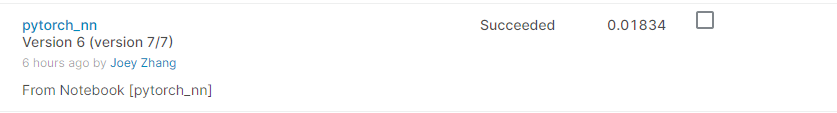